In [ ]:
using LibPQ, Tables, Plots, HTTP, CSV, Random, StatsBase, FreqTables, SQLite, Base, Dates, JuliaDB, StatsPlots
using Base: show_supertypes
plotly()


In [ ]:
import Pkg; Pkg.add("StatsPlots")

Fact:
let `rd` be the daily rate (not in percentage, but in absolute terms).
then `ry` the yearly rate is given by 
```
ry = (1+rd)^365 - 1
```

This is a crazy exponential equation. An yearly rate of `10%` is achived by a daily rate of around `0.03%`
The following graph plots the relation 


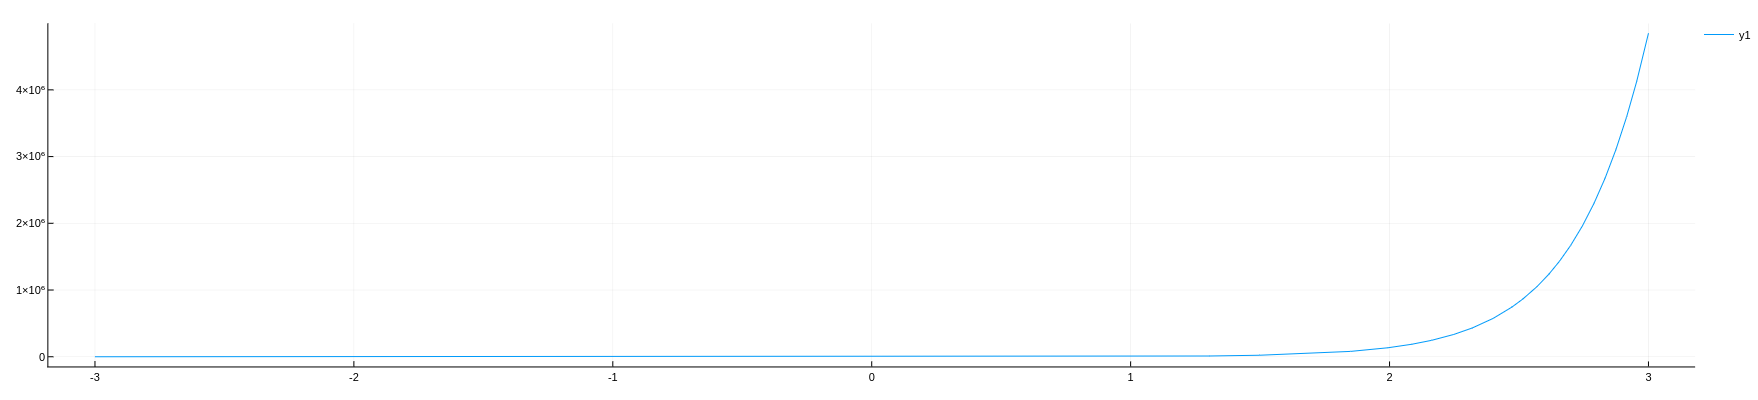

In [227]:
x = -0.03:0.00001:0.03
y = map(i -> (1+i)^365-1, x)
doplot(x.*100, y.*100)


In [ ]:
function p2(p1::Number, r::Number, t::Number)
    return Float64(p1)*((1+Float64(r))^Float64(t))
end

function t(p1::Number, p2::Number, r::Number)
    return log(Float64(p2)/Float64(p1)) / log(1+Float64(r))
end

function p1(p2::Number, r::Number, t::Number)
    return Float64(p2)/((1+Float64(r))^Float64(t))
end

function r(p1::Number, p2::Number, t::Number)
    power = log(Float64(p2)/Float64(p1))/Float64(t)
    return exp(power) - 1
end

function emi(p1::Number, r::Number, t::Number)
    x::Float64 = (1.0 + Float64(r))^Float64(t)
    return Float64(p1) * Float64(r) * x / (x - 1)
end

conn = LibPQ.Connection("dbname=sharath")
sqlite = SQLite.DB()

In [ ]:
struct Point
    dates::Array{DateTime}
    prices::Array{Float64}
end


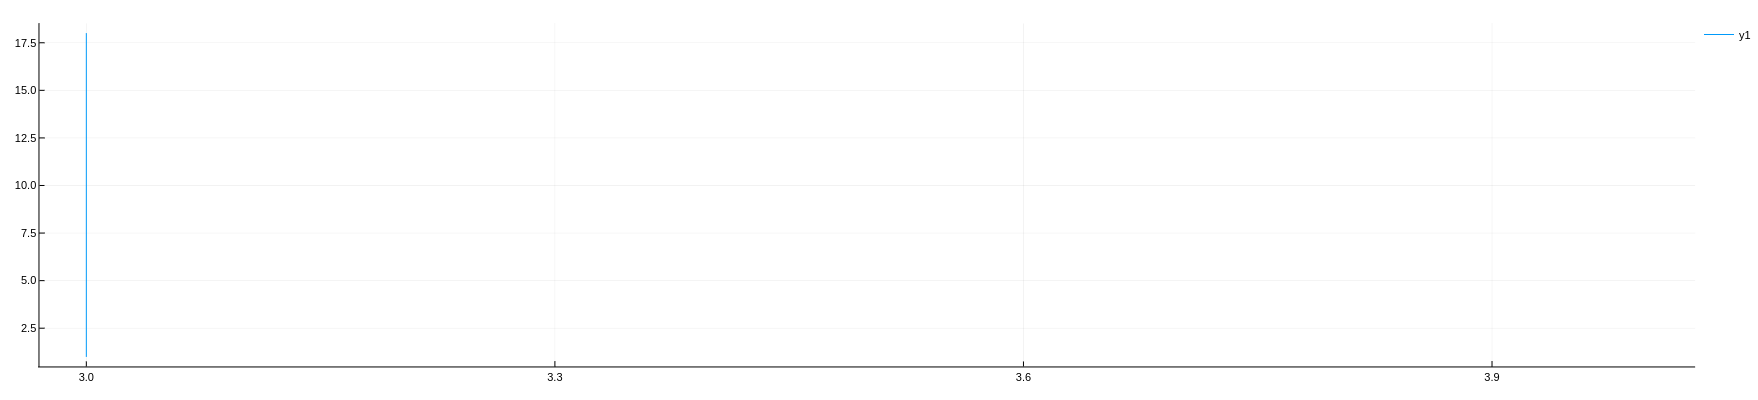

fmt (generic function with 2 methods)

In [190]:
function getSeries(symbol::String)
    sql = """select date, adjclose from nse_raw nr where symbol = '"""*symbol*"""' and adjclose is not null order by 1 """
    result = execute(conn, sql)
    println(show_supertypes(typeof(result)))
    return result |> table
end
#v2 a linear time algorithm for calculating sip returns. returns an array of returns.
# each element corresponds to a period of sipDurationDays
function sipv2(sipFrequencyDays::Int, sipDurationDays::Int, series)
    series2 = Array{Float64}(undef, 0)
    stocksNow = 0.0
    for i in 1:sipFrequencyDays:length(series)
        append!(series2, series[i])
    end
    n = size(series2)[1]
    rates = Vector{Float64}(undef, 0)
    stocks::Float64 = 0.0
    sipDurationDays = min(n, convert(Int64, floor(sipDurationDays/sipFrequencyDays)))

    
    for i in 1:sipDurationDays
        stocks+=1/series2[i]
    end
    append!(rates, r(sipDurationDays, series[sipDurationDays]*stocks, sipDurationDays/365.0))

    for i in 2:n-sipDurationDays+1
        stocks -= 1/series[i-1]
        stocks += 1/series[i+sipDurationDays-1]
        rate = r(sipDurationDays, series[i+sipDurationDays-1]*stocks, sipDurationDays/365.0)
        append!(rates, r(sipDurationDays, series[i+sipDurationDays-1]*stocks, sipDurationDays/365.0))
    end
    return rates
end
# println(typeof(returns[1, :]))
function gogo(symbol)
    years = 1:7
    returns = Array{Float64}(undef, 101, length(years))

    for year in years
        returns[:, year] = nquantile(sipv2(1, (year)*365, d[symbol].prices), 100).*100
    end
    return plot(collect(1:101), returns, label = permutedims(["year"*string(x) for x in years])) 
end
function constructDict()
    data = columntable(execute(conn, """ select symbol, date, adjclose from nse_raw where date is not null and adjclose is not null order by 1, 2"""))
    symbols = copy(data[1])
    dates = copy(data[2])
    adjclose = copy(data[3])
    d = Dict{String, Point}()
    for i in 1:length(symbols)
        symbol = symbols[i]
        date = dates[i]
        price = adjclose[i]
        if price < 1
            continue
        end
        if !haskey(d, symbol)
            d[symbol] = Point(Array{DateTime}(undef, 0), Array{Float64}(undef, 0))
        end
        point = d[symbol]
        push!(point.dates, dates[i])
        push!(point.prices, max(0, adjclose[i]))
    end
    return d
end
function prob(d::Dict{String, Point}, company::String, sipFrequencyDays::Int, sipDurationDays::Int, targetRate::Float64=0.1)
    series = d[company].prices
    returns = sipv2(sipFrequencyDays::Int, sipDurationDays::Int, series)
    sorted = sort(returns)
    bottom = length(returns)
    top = min(bottom, first(searchsorted(sorted, targetRate)))
    return (bottom-top)/bottom
end

function doplot(d::Dict{String, Point})
    k = collect(keys(d))
    tuples = [(i, prob(d, i, 1, 3*365, 0.1)) for i in k]
    filter(x->x[2]>0.7,sort!( tuples, by=last))
    
#     return plot(getindex.(tuples,1), getindex.(tuples, 2))
end
function doplot(x, y)
    plot(x, y; hover=fmt.(x).*"   ".*fmt.(y), size=(1700, 400,))
end

function stock(symbol::String)
    display(plot(d[symbol].dates, d[symbol].prices, title="stock prices"; hover=fmt.(d[symbol].dates).*"   ".*string.(d[symbol].prices), size=(1700, 400,)))
#     display(gogo(symbol))
end

function fti(x::Number)
    return convert(Int64, round(Float64(x)))
end
function fmt(d::DateTime)
    Dates.format(d, "yyyy-mm-dd")
end
function fmt(d::Any)
    string(d)
end

In [ ]:
d = constructDict()

In [ ]:
# returns the probability that the sip makes a return of targetRate considering every possible period whose duration is sipDurationDays

println(doplot(d))
# (filter(x->x[2]<0 , collect(zip(1:length(d["INFY"]), [p.price for p in d["INFY"]]))))
# zip(1:length(d["INFY"]), [p.price for p in d["INFY"]])
# filter(p -> p[1]<0, )
# prob(d, "UJJIVANSFB", 1, 100, 0.1)
# [p.price for p in (d["INFY"][:4])]
# println(([p.price for p in d["INFY"][2000:2010]]))

In [ ]:
show_supertypes(typeof(data.NDP_Date))

In [198]:
function consecutiveReturns(infp::Array{Float64}, infd::Array{DateTime})
    infi = map(x->convert(Int64, (x-infyd[1]).value/86400000), infyd)
    ans = Array{Float64}(undef, length(infi)-1)
    for i in 2:length(infp)
        diff = (infi[i]-infi[i-1])
        ans[i-1] = r(infp[i-1], infp[i], (infi[i]-infi[i-1]))*100
    end
    println(collect(zip(infp, infi, [0; ans])))    
    return ans
end
consecutiveReturns(d["INFY"].prices[2500:2510], d["INFY"].dates[2500:2510])
1

[(97.083649, 0, 0.0), (99.51320600000001, 1, 2.502539845818963), (100.096298, 2, 0.5859443418996912), (98.52018699999999, 3, -1.5745946967988922), (101.16413100000001, 4, 2.6836571067409887), (99.22627299999999, 7, -0.6426404848424605), (98.322334, 8, -0.9109875566927661), (100.638512, 9, 2.3556987571104804), (100.49389599999999, 10, -0.14369846803777842), (98.474281, 11, -2.009689225303779), (99.486603, 14, 0.34150127136658437)]


1

In [216]:
r(97.083649, 99.51320600000001, 1)

0.02502539845818963

8282.066656629759


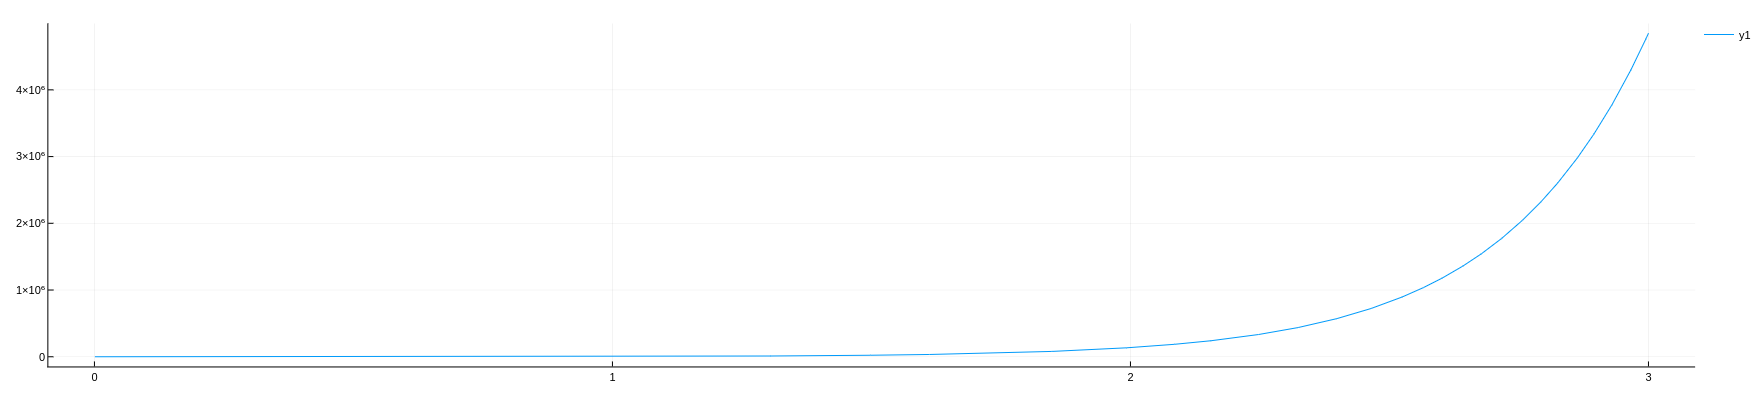

In [225]:
println((1+0.02502539845818963)^365)
r(97.083649, 99.51320600000001, 1/365)
x = 0.00001:0.00001:0.03
y = map(i -> (1+i)^365-1, x)
doplot(x.*100, y.*100)

In [203]:
function consecutiveReturns(infp::Array{Float64}, infd::Array{DateTime})
    infi = map(x->convert(Int64, (x-infyd[1]).value/86400000), infyd)
    ans = Array{Float64}(undef, length(infi)-1)
    for i in 2:length(infp)
        diff = (infi[i]-infi[i-1])
        ans[i-1] = r(infp[i-1], infp[i], (infi[i]-infi[i-1])/365)*100/365
    end
    println(collect(zip(infp, infi, [0; ans])))    
    return ans
end
consecutiveReturns(d["INFY"].prices[2500:2510], d["INFY"].dates[2500:2510])
1

[(97.083649, 0, 0.0), (99.51320600000001, 1, 2268.7853853780152), (100.096298, 2, 2.037138169418137), (98.52018699999999, 3, -0.27313730855996377), (101.16413100000001, 4, 4321.79586208791), (99.22627299999999, 7, -0.24792773102331753), (98.322334, 8, -0.2642671752059373), (100.638512, 9, 1344.3385671855738), (100.49389599999999, 10, -0.11188264223917421), (98.474281, 11, -0.27380681537786217), (99.486603, 14, 0.6769039185501194)]


1

In [ ]:
typeof(infyi)

In [ ]:
infyi[1:end]

In [ ]:
function ohlc2()
    function get_ohlc(ticker; kwargs...)
        res = HTTP.get("https://www.quandl.com/api/v3/datasets/WIKI/$(ticker)/data.csv?start_date=2017-01-01")
        df = CSV.read(res.body)
        ohlc(df, x=:Date, open=:Open, high=:High, low=:Low, close=:Close; kwargs...)
    end

    p1 = plot(get_ohlc("AAPL", name="Apple"), Layout(title="Apple"))
    p2 = plot(get_ohlc("GOOG", name="Google"), Layout(title="Google"))

    [p1 p2]
end
ohlc2()

In [ ]:
death = 100
age = 37
months = (death - age)*12
inflationPerMonth = 6/(100*12)
monthlyCost = 100000
living = monthlyCost * months
println(living)
marriage = 1000000
# education is 100000 per year (present value) starting from 5th year to 5+16 years

education = 16*100000
total = living + marriage + 2*education
println(total)

In [ ]:
df = CSV.read("/home/sharath/Downloads/AdultDataSet.csv")

In [ ]:
df2 = df[shuffle(1:nrow(df))[1:Int(floor((nrow(df)/5)))], :]

In [ ]:
plot([histogram(x=randn(10000), opacity=0.75)], Layout(barmode="overlay"))



In [ ]:
filter(row->row["education"]==" HS-grad" && row["marital-status"]==" Never-married", df)

In [ ]:
typeof(freqtable(df["education"], df["marital-status"]))

In [ ]:
df |> SQLite.load!(sqlite, "adult")

In [ ]:
df = DBInterface.execute(sqlite, "select * from adult") |> DataFrame

# Experimentation on multidimensional array speeds

array iteration speed is about 1 billion per second. insane.

In [ ]:
function test(ar::Array{Int64})
    sum = 0
    for i in 1:1000
        for j in 2:length(ar)
            sum+=ar[j]
#             ar[j]+=ar[j-1]
        end
    end
    return sum
end
time_sum(x) = @time test(x);
time_sum(ar)
println(typeof(ar), size(ar))


# Speeds of DataFrames
fucking dataframes is not type stable so it is 100-1000x slower than array iteration and allocates a large amount of memory

There are several table like structures in julia (mostly third parties, several of them seem to be overlapping a lot in functionality)
The best one seems to be IndexedTable. it is type stable. It is implementated as a NamedTuple of vectors but acts like a vector of NamedTuples.
Of course, the fastest and most native is just NamedTuple. But it seems like a NamedTuple (and also IndexedTable) with many columns might stress the compiler (havent tested it)

IndexedTable constructor *copies* the data from the NamedTuple constructor param to create the new IndexedTable. However, invoking `IndexedTable.columns ` returns a NamedTuple *view* of the IndexedTable which is perfect for arbitrary iteration and modifications.

btw, the nomenclature is really fucked up.
- [Julia Data](https://github.com/JuliaDatahttps://github.com/JuliaData) is the name for all built in table like structures in Julia. They all seem to respect the Tables.jl interface
- [JuliaDB](https://juliadata.github.io/JuliaDB.jl/latest/https://juliadata.github.io/JuliaDB.jl/latest/) is one particular table like structure in Julia Data. It is built on `IndexedTables` (seems like both are synonymous). This is the best since it is type stable
- [DataFrames](https://github.com/JuliaData/DataFrames.jlhttps://github.com/JuliaData/DataFrames.jl) is a slow and fucked up implementation in Julia Data. It is feature rich but fucking slow
- [Julia Databases](https://juliadatabases.github.io/https://juliadatabases.github.io/) collects various drivers for different databases like Mysql, postgres, sqlite. seems like all of them can stream to a tables.jl constructor

A good summary of all the shit can be found [here](https://www.juliabloggers.com/a-tour-of-the-data-ecosystem-in-julia/https://www.juliabloggers.com/a-tour-of-the-data-ecosystem-in-julia/) from the author of CSV.jl

In [ ]:
function testDataFrame(df::DataFrame)
    ar::Array{Int64} = df.a
    sum = 0
    for i::Int64 in 1:1000
        for j in 1:length(ar)
            sum+=ar[j]
        end
    end
    return sum
end


# println(typeof(df))
time_sum(df) = @time testDataFrame(df);
time_sum(df)
